In [18]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import os

# --- PROJECT CONFIGURATION ---
PROJECT_NAME = "NeuroLink Analytics"
TARGET_WPM = 130
TARGET_ACCURACY = 0.99
DATA_FILE = 'typing-data.json'
OUTPUT_IMAGE = 'neurolink_dashboard.png'

def run_neurolink_pipeline():
    # 1. LOAD AND ENRICH DATA
    with open(DATA_FILE, 'r') as f:
        data = json.load(f)

    session_rows = []
    char_rows = []

    for session in data:
        ts = pd.to_datetime(session['timeStamp'])

        # Aggregate histogram for accuracy and char-level stats
        hits, misses = 0, 0
        hist = session.get('histogram', [])
        for entry in hist:
            h, m = entry['hitCount'], entry['missCount']
            hits += h
            misses += m
            char_rows.append({
                'char': chr(entry['codePoint']),
                'hits': h,
                'misses': m,
                'latency': entry['timeToType']
            })

        acc = hits / (hits + misses) if (hits + misses) > 0 else 0

        session_rows.append({
            'timestamp': ts,
            'date': ts.date(),
            'wpm': session['speed'] / 5,  # Convert CPM to WPM
            'accuracy': acc
        })

    df = pd.DataFrame(session_rows).sort_values('timestamp').reset_index(drop=True)
    df['session_id'] = df.index + 1
    df['session_of_day'] = df.groupby('date').cumcount() + 1
    df_chars = pd.DataFrame(char_rows)

    # 2. FORECASTING ENGINE
    def get_forecast(target_val, col_name):
        X = df[['session_id']].values
        y = df[col_name].values
        model = LinearRegression().fit(X, y)
        slope = model.coef_[0]
        intercept = model.intercept_

        if slope <= 0: return None, None, slope

        target_session = (target_val - intercept) / slope

        # Date estimation based on historical frequency
        days_span = (df['timestamp'].max() - df['timestamp'].min()).days
        freq = len(df) / max(days_span, 1)
        days_remaining = (target_session - len(df)) / freq
        target_date = df['timestamp'].max() + timedelta(days=days_remaining)

        return int(target_session), target_date, slope

    wpm_sess, wpm_date, wpm_slope = get_forecast(TARGET_WPM, 'wpm')
    acc_sess, acc_date, _ = get_forecast(TARGET_ACCURACY, 'accuracy')

    # 3. GENERATE DASHBOARD
    plt.style.use('ggplot')
    fig, axes = plt.subplots(2, 2, figsize=(16, 11))
    fig.suptitle(f'{PROJECT_NAME}: Performance & Mastery Forecast', fontsize=22, fontweight='bold', y=0.98)

    # Plot A: Speed Trend & Goal
    axes[0, 0].scatter(df['session_id'], df['wpm'], color='gray', alpha=0.1, s=2)
    axes[0, 0].plot(df['session_id'], df['wpm'].rolling(100).mean(), color='#3498db', linewidth=2.5, label='100-Session SMA')
    axes[0, 0].axhline(TARGET_WPM, color='#e74c3c', linestyle='--', linewidth=2, label=f'Goal: {TARGET_WPM} WPM')
    axes[0, 0].set_title('Velocity Projection (WPM)', fontsize=14, pad=10)
    axes[0, 0].set_ylabel('Words Per Minute')
    axes[0, 0].legend()

    # Plot B: Accuracy Trend & Goal
    axes[0, 1].plot(df['session_id'], df['accuracy'].rolling(100).mean(), color='#27ae60', linewidth=2.5)
    axes[0, 1].axhline(TARGET_ACCURACY, color='#e74c3c', linestyle='--', linewidth=2, label=f'Goal: {int(TARGET_ACCURACY*100)}%')
    axes[0, 1].set_title('Precision Optimization (%)', fontsize=14, pad=10)
    axes[0, 1].set_ylabel('Accuracy %')

    # Plot C: Fatigue / Warm-up Effect
    fatigue = df.groupby('session_of_day')['wpm'].mean().head(25)
    axes[1, 0].bar(fatigue.index, fatigue.values, color='#f39c12', alpha=0.8)
    axes[1, 0].set_title('The Warm-up Effect (Avg Speed by Session #)', fontsize=14, pad=10)
    axes[1, 0].set_xlabel('Session Number in a Day')
    axes[1, 0].set_ylabel('Avg WPM')

    # Plot D: Hardest Keys
    char_agg = df_chars.groupby('char').agg({'hits': 'sum', 'misses': 'sum'}).reset_index()
    char_agg['error_rate'] = char_agg['misses'] / (char_agg['hits'] + char_agg['misses'])
    top_errors = char_agg.sort_values('error_rate', ascending=False).head(10)

    sns.barplot(data=top_errors, x='char', y='error_rate', ax=axes[1, 1], palette='flare', hue='char')
    if axes[1, 1].legend_: axes[1, 1].legend_.remove()

    axes[1, 1].set_title('Character Bottlenecks (Top 10 Errors)', fontsize=14, pad=10)
    axes[1, 1].set_ylabel('Error Probability')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(OUTPUT_IMAGE)

    return wpm_sess, wpm_date, acc_sess, acc_date

wpm_sess, wpm_date, acc_sess, acc_date = run_neurolink_pipeline()
print(f"Speed Target: {wpm_sess} sessions on {wpm_date.date()}")
print(f"Accuracy Target: {acc_sess} sessions on {acc_date.date()}")


Speed Target: 31919 sessions on 2026-05-27
Accuracy Target: 30659 sessions on 2026-05-06


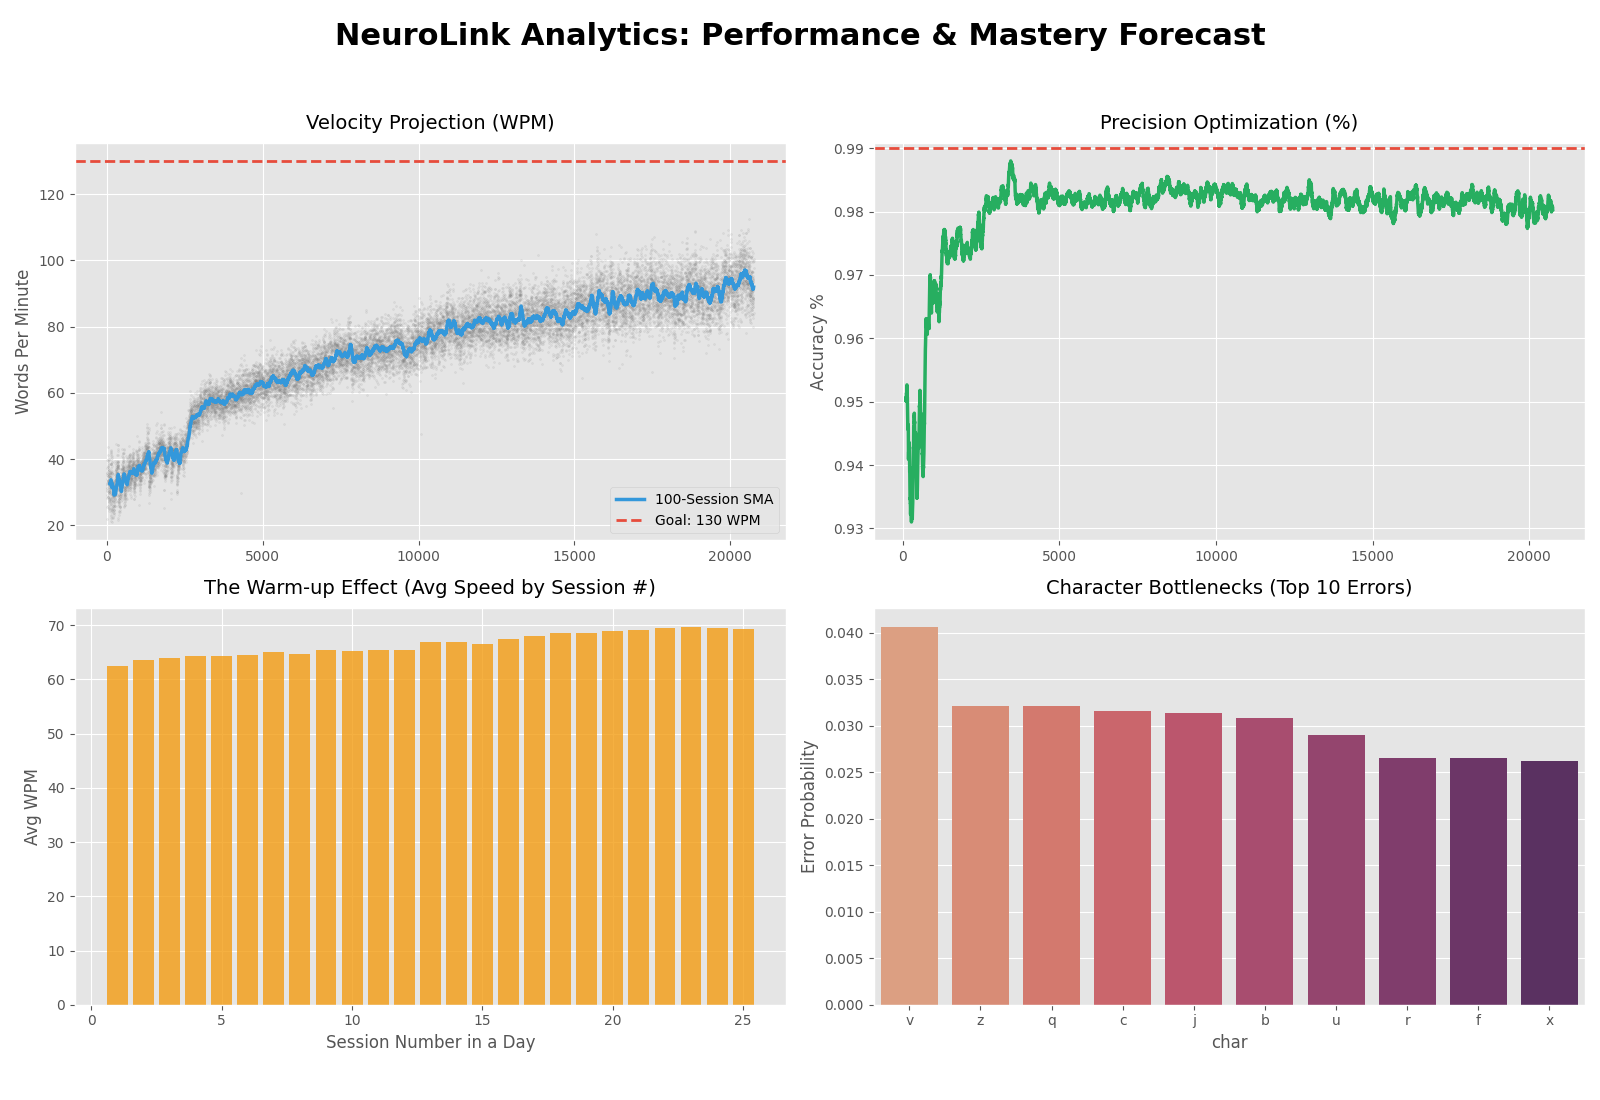

In [22]:
from IPython.display import Image
Image(filename='neurolink_dashboard.png')